In [7]:
import os
from io import open
import glob

import unicodedata
import string

# 1. Getting data ready

In [4]:
os.listdir("./data/")

['names', 'eng-fra.txt']

In [5]:
def find_files(path):
    return glob.glob(path)

In [6]:
print(find_files("./data/names/*.txt"))

['./data/names/Czech.txt', './data/names/German.txt', './data/names/Arabic.txt', './data/names/Japanese.txt', './data/names/Chinese.txt', './data/names/Vietnamese.txt', './data/names/Russian.txt', './data/names/French.txt', './data/names/Irish.txt', './data/names/English.txt', './data/names/Spanish.txt', './data/names/Greek.txt', './data/names/Italian.txt', './data/names/Portuguese.txt', './data/names/Scottish.txt', './data/names/Dutch.txt', './data/names/Korean.txt', './data/names/Polish.txt']


# 2. Removing accents from texts

In [10]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [13]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [12]:
n_letters

57

In [8]:
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [14]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


# Category_lines dictionary and a list of names per language

In [15]:
def read_lines(filename):
    lines = open(filename, encoding="utf-8").read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [24]:
# example lines:
filename = find_files("./data/names/*.txt")[0]

lines = read_lines(filename)
print("category : ", os.path.splitext(os.path.basename(filename))[0])
print(lines[:10])

category :  Czech
['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch', 'Antonowitz', 'Bacon', 'Ballalatak', 'Ballaltick', 'Bartonova']


In [28]:
# categories for names
all_categories = [os.path.splitext(os.path.basename(f))[0] for f in find_files("./data/names/*.txt")]

# list of names for the category
category_names = {}


for filename in find_files("./data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    
    lines = read_lines(filename)
    
    category_names[category] = lines

n_categories = len(all_categories)

In [29]:
print(all_categories)

['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']


In [32]:
print(category_names["German"][:10])

['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles', 'Achterberg', 'Acker', 'Ackermann', 'Adam', 'Adenauer']


# 3. Names to tensors

In [93]:
import torch
import torch.nn as nn

import random
import matplotlib.pyplot as plt


from tqdm import tqdm

In [37]:
n_letters

57

In [40]:
# letter2index : a = 0, b = 1 ...
def letter2index(letter):
    return all_letters.find(letter)


# Turn a name into a tensor of <name_length x 1 x n_letters>
# this is array of one-hot encoded vectors
def name2tensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    
    for idx, letter in enumerate(name):
        tensor[idx][0][letter2index(letter)] = 1
    return tensor

print(name2tensor("Jason"))
print(name2tensor("Jason").size())

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

# 4. Creating the network

## 4.1 Simple RNN

In [76]:
class RNN(nn.Module):
    def __init__(self, data_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        input_size = data_size + hidden_size
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, data, last_hidden):
        input_tensor = torch.cat((data, last_hidden), 1)
        hidden = self.fc1(input_tensor)
        output = self.fc2(hidden)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

# getting category from output
def category_from_output(output):
    top_n,top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

### 4.1.1 Initialise the networks

In [77]:
data_size = n_letters
hidden_size = 128
output_size = n_categories

rnn = RNN(data_size, hidden_size, output_size)

### 4.1.2 Training single step of the network

To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [78]:
# 1 step of the network
input_tensor = name2tensor("A")
hidden_tensor = torch.zeros(1, hidden_size)

output, next_hidden = rnn(input_tensor[0], hidden_tensor)

In [79]:
output

tensor([[-2.9947, -2.8268, -2.8289, -2.8847, -2.8716, -2.8546, -2.8696, -2.8195,
         -3.0354, -2.8389, -2.9797, -2.8690, -2.8825, -2.8826, -2.8816, -2.9452,
         -2.9908, -2.8089]], grad_fn=<LogSoftmaxBackward>)

In [80]:
category_from_output(output)

('Polish', 17)

### 4.1.3 Function to get the training examples

In [81]:
all_categories.index("French")

7

In [82]:


def random_choice(l):
    return l[random.randint(0,len(l)-1)]

def random_training_example():
    category = random_choice(all_categories)
    name = random_choice(category_names[category])
    
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    name_tensor = name2tensor(name)
    
    return category, name, category_tensor, name_tensor

In [83]:
for i in range(10):
    category, name, category_tensor, name_tensor = random_training_example()
    print("category = ", category, "| name = ", name)

category =  Scottish | name =  Alexander
category =  Korean | name =  So
category =  Korean | name =  Baik
category =  Scottish | name =  Jamieson
category =  French | name =  Cavey
category =  Spanish | name =  Mendez
category =  Scottish | name =  Mackenzie
category =  Russian | name =  Abelmazoff
category =  Irish | name =  O'Keefe
category =  Korean | name =  Chi


### 4.1.4 Training the network

In [84]:
def train(category_tensor, name_tensor, loss_func, learning_rate):
    hidden_tensor = rnn.init_hidden()
    
    rnn.zero_grad()
    
    for i in range(name_tensor.size()[0]):
        output, hidden_tensor = rnn(name_tensor[i], hidden_tensor)
    
    loss = loss_func(output, category_tensor)
    loss.backward()
    
    # Gradient descent
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    
    return output, loss.item()

In [91]:
learning_rate = 0.005 
current_loss = 0
n_iters = 100000
plot_freq = 1000

loss_func = nn.NLLLoss()

In [92]:
all_losses = []
iteration_list = []

# running trianing
for idx in tqdm(range(1, n_iters+1)):
    category, name, category_tensor, name_tensor = random_training_example()
    output, loss = train(category_tensor, name_tensor, loss_func, learning_rate)
    
    current_loss += loss
    
    if idx%plot_freq == 0:
            iteration_list.append(idx)
            all_losses.append(current_loss/plot_freq)
            iteration_list.append(idx)
            current_loss = 0

100%|██████████| 100000/100000 [02:14<00:00, 742.38it/s]


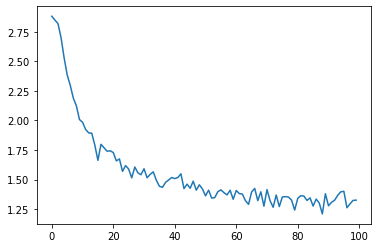

In [94]:
plt.plot(all_losses)

### 4.1.5 Lets check for some examples of the trained network

In [99]:
def evaluate(name_tensor):
    hidden_tensor = rnn.init_hidden()
    
    for i in range(name_tensor.size()[0]):
        output, hidden_tensor = rnn(name_tensor[i], hidden_tensor)
    return output


def predict(input_name, n_predictions=3):
    print("name > ", input_name)
    with torch.no_grad():
        output = evaluate(name2tensor(input_name))
        
        # get top N categories
        top_values, top_idx = output.topk(n_predictions, 1, True)
        
        for i in range(n_predictions):
            value = top_values[0][i].item()
            category_index = top_idx[0][i].item()
            
            print("%.2f : %s"%(value, all_categories[category_index]))
            

In [102]:
predict("Jason")

name >  Jason
-0.31 : Scottish
-2.45 : Polish
-2.67 : Korean


In [106]:
predict("Ashna")

name >  Ashna
-1.40 : Japanese
-1.75 : Italian
-1.84 : Arabic


In [107]:
predict("Henry")

name >  Henry
-1.28 : English
-1.57 : Irish
-1.96 : Scottish


In [105]:
predict("Dovesky")

name >  Dovesky
-0.09 : Russian
-2.95 : Czech
-4.21 : Irish


In [109]:
predict("Macron")

name >  Macron
-1.05 : Scottish
-1.32 : French
-2.39 : Spanish


In [118]:
predict("Uwe")

name >  Uwe
-1.46 : English
-1.78 : Scottish
-2.01 : German


In [120]:
predict("Galina")

name >  Galina
-0.70 : Italian
-1.55 : Spanish
-2.44 : Irish


In [122]:
predict("Ludimila")

name >  Ludimila
-0.43 : Italian
-2.46 : Russian
-2.59 : Spanish
